**Implementasi SVM untuk Analisis dan Prediksi Sentimen pada Data IndoNLU**

Dataset: https://github.com/indobenchmark/indonlu

# **Membaca Data**

Impor library

In [1]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn import svm
from sklearn.metrics import classification_report

Memuat data IndoNLU

In [2]:
!git clone https://github.com/indobenchmark/indonlu

Cloning into 'indonlu'...
remote: Enumerating objects: 500, done.
remote: Counting objects: 100% (184/184), done.
remote: Compressing objects: 100% (74/74), done.
remote: Total 500 (delta 115), reused 139 (delta 110), pack-reused 316
Receiving objects: 100% (500/500), 9.45 MiB | 17.37 MiB/s, done.
Resolving deltas: 100% (235/235), done.


# **Mempersiapkan Data**

In [3]:
data_train = pd.read_csv('/content/indonlu/dataset/smsa_doc-sentiment-prosa/train_preprocess.tsv', sep='\t')
data_train.head()

,"warung ini dimiliki oleh pengusaha pabrik tahu yang sudah puluhan tahun terkenal membuat tahu putih di bandung . tahu berkualitas , dipadu keahlian memasak , dipadu kretivitas , jadilah warung yang menyajikan menu utama berbahan tahu , ditambah menu umum lain seperti ayam . semuanya selera indonesia . harga cukup terjangkau . jangan lewatkan tahu bletoka nya , tidak kalah dengan yang asli dari tegal !",positive
0,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral
1,lokasi strategis di jalan sumatera bandung . t...,positive
2,betapa bahagia nya diri ini saat unboxing pake...,positive
3,duh . jadi mahasiswa jangan sombong dong . kas...,negative
4,"makanan beragam , harga makanan di food stall ...",positive


In [4]:
# Membuat header pada tabel
data_train = pd.read_csv('/content/indonlu/dataset/smsa_doc-sentiment-prosa/train_preprocess.tsv', sep='\t', names=["Teks", "Target"])
data_test = pd.read_csv('/content/indonlu/dataset/smsa_doc-sentiment-prosa/valid_preprocess.tsv', sep='\t', names=["Teks", "Target"])

data_train.head(5)

,Teks,Target
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral
2,lokasi strategis di jalan sumatera bandung . t...,positive
3,betapa bahagia nya diri ini saat unboxing pake...,positive
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative


# **Analisis Data**

In [5]:
# Melihat jumlah data pada data train dan test
print(data_train.shape)
print(data_test.shape)

(11000, 2)
(1260, 2)


In [6]:
# Menghitung jumlah data masing-masing variabel pada kolom Target
data_train['Target'].value_counts()

positive    6416
negative    3436
neutral     1148
Name: Target, dtype: int64

## **Visualisasi Distribusi Variabel**

<Axes: xlabel='Target'>

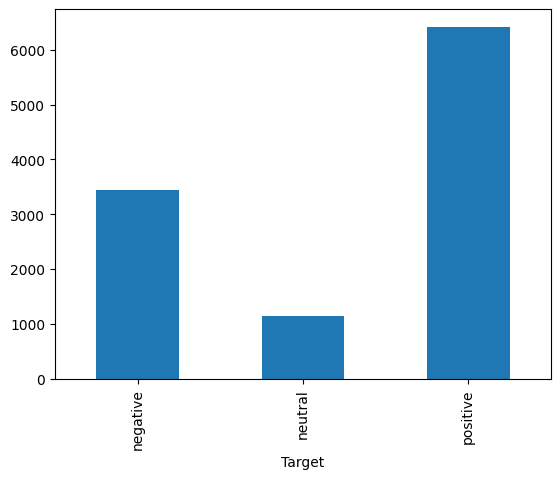

In [7]:
# Memvisualisasikan data untuk mendapatkan ilustrasi distribusi variabel
data_train.groupby('Target').size().plot(kind='bar')

Berdasarkan grafik ilustrasi distribusi variabel diatas, nilai positif lebih banyak dibandingkan dengan nilai negatif dan netral. Hal ini menunjukkan bahwa secara umum, teks-teks dalam dataset IndoNLU memiliki sentimen yang positif

## **Visualisasi Panjang Teks**

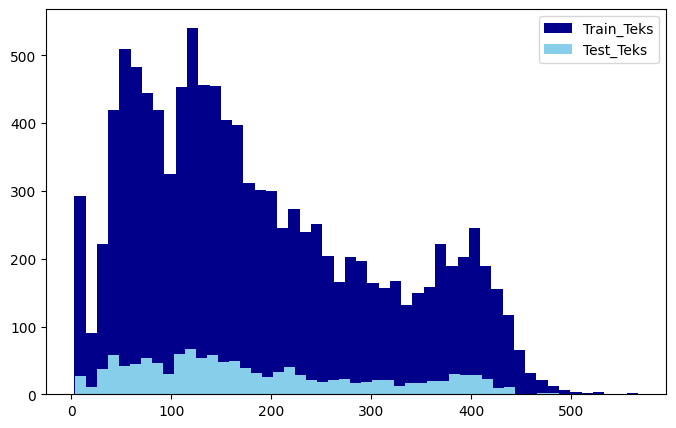

In [8]:
# Melihat panjang teks dalam data train dan data test
length_train = data_train['Teks'].str.len()
length_test = data_test['Teks'].str.len()
plt.figure(figsize=(8,5))
plt.hist(length_train, bins=50, label="Train_Teks", color = "darkblue")
plt.hist(length_test, bins=50, label='Test_Teks', color = "skyblue")
plt.legend()

Berdasarkan grafik diatas, sebagian besar teks dalam dataset pelatihan memiliki panjang (kata/karakter) antara 0 hingga sekitar 200. Terdapat puncak pada panjang teks tertentu, sekitar 50 dan 150 untuk data pelatihan

## **Visualisasi Sentimen dengan Word Cloud**

Word cloud pada data train dan test

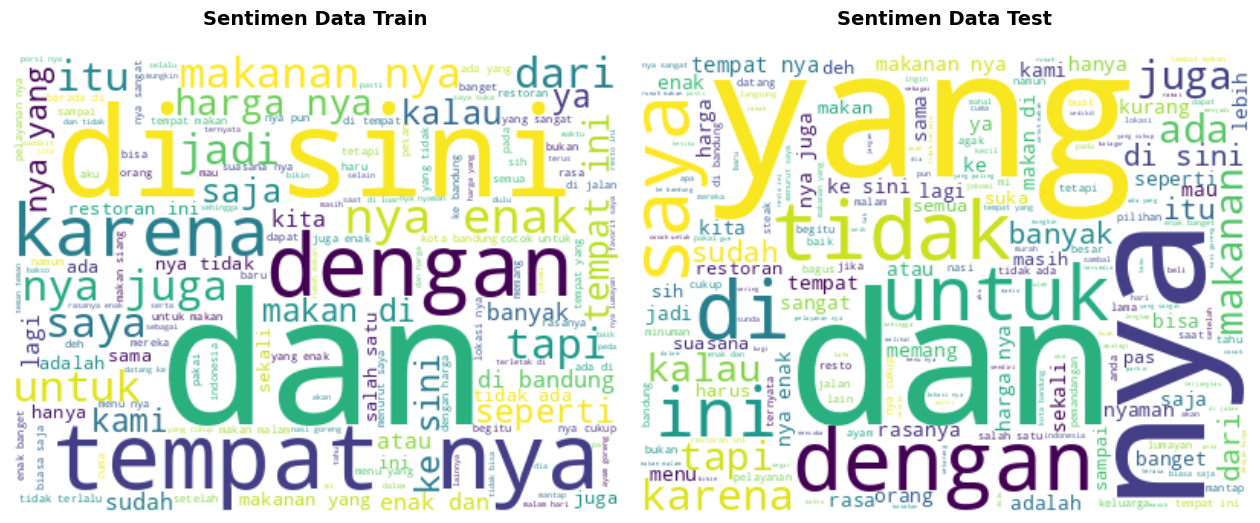

In [9]:
# Fungsi untuk menampilkan word cloud
def display_wordcloud(ax, words=None, title=None, fontweight=None, fontsize=None):
    wordcloud = WordCloud(width=400, height=300, background_color='white', random_state=21, max_font_size=120).generate(words)

    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')
    ax.set_title(title, fontweight=fontweight, fontsize=fontsize)

fig, axs = plt.subplots(1, 2, figsize=(16, 10))

# Word cloud untuk data train
all_words_train = ' '.join([text for text in data_train['Teks']])
display_wordcloud(axs[0], all_words_train, 'Sentimen Data Train\n', fontweight='bold', fontsize=14)

# Word cloud untuk data test
all_words_test = ' '.join([text for text in data_test['Teks']])
display_wordcloud(axs[1], all_words_test, 'Sentimen Data Test\n', fontweight='bold', fontsize=14)

plt.subplots_adjust(wspace=0.03)
plt.show()

Word cloud sentimen negatif

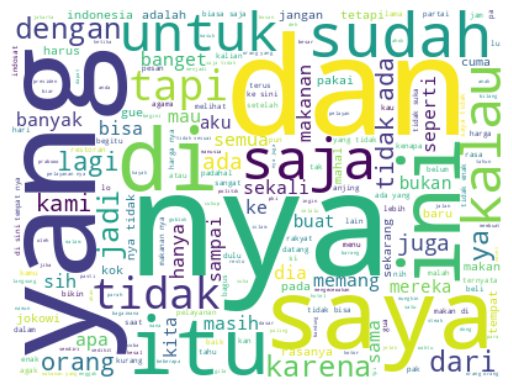

In [10]:
# Word cloud kata-kata negatif
negative_words = ' '.join(text for text in data_train['Teks'][data_train['Target'] == 'negative'])
display_wordcloud(plt.gca(), negative_words)

Word cloud sentimen netral

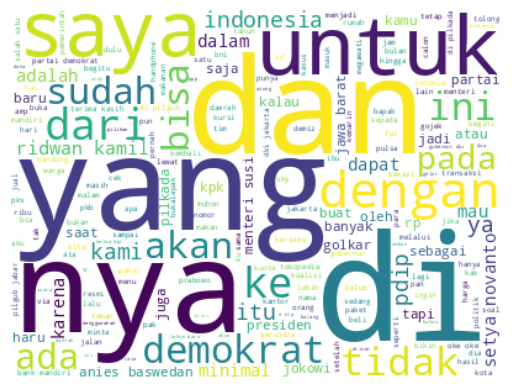

In [11]:
# Word cloud kata-kata netral
neutral_words = ' '.join(text for text in data_train['Teks'][data_train['Target'] == 'neutral'])
display_wordcloud(plt.gca(), neutral_words)

Word cloud sentimen positif

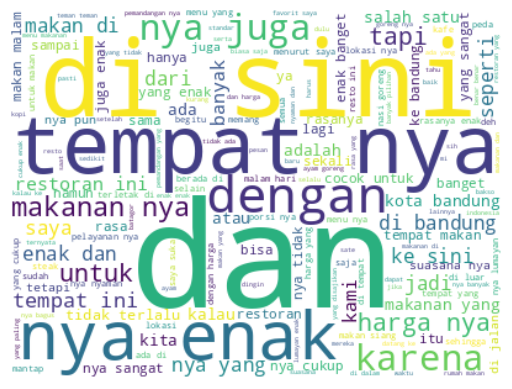

In [12]:
# Word cloud kata-kata positif
positive_words = ' '.join(text for text in data_train['Teks'][data_train['Target'] == 'positive'])
display_wordcloud(plt.gca(), positive_words)

# **Feature Engineering dengan TF-IDF**

In [13]:
# Melakukan vektorisasi untuk mengekstrak fitur dengan TF-IDF
vectorizer = TfidfVectorizer(min_df = 5,  # Menghilangkan istilah yang terlalu jarang muncul
                             max_df = 0.8,  # Menghilangkan term yang terlalu sering muncul
                             sublinear_tf = True,  # Normalisasi bias terhadap teks yang panjang dan teks yang pendek
                             use_idf = True)  # Istilah yang terlalu sering muncul dalam teks akan diberi skor lebih sedikit dibanding istilah yang jarang muncul

train_vectors = vectorizer.fit_transform(data_train['Teks'])
test_vectors = vectorizer.transform(data_test['Teks'])

# **Klasifikasi Sentimen dengan Support Vector Machine**

In [14]:
# Melakukan klasifikasi dengan SVM, kernel=linear
classifier_linear = svm.SVC(kernel='linear')
classifier_linear.fit(train_vectors, data_train['Target'])
prediction_linear = classifier_linear.predict(test_vectors)

In [15]:
# Untuk melihat metriks precision, recall, F1-score dan support pada model
target_names = ['positive', 'negative', 'neutral']
print(classification_report(data_test['Target'], prediction_linear, target_names=target_names))

              precision    recall  f1-score   support

    positive       0.81      0.86      0.84       394
    negative       0.79      0.70      0.74       131
     neutral       0.92      0.91      0.91       735

    accuracy                           0.87      1260
   macro avg       0.84      0.82      0.83      1260
weighted avg       0.87      0.87      0.87      1260



Dari hasi metriks model diatas menunjukkan kinerja yang baik dalam memprediksi sentimen teks, dengan akurasi keseluruhan 87%

Model ini lebih baik dalam mengklasifikasikan teks dengan sentimen "positive" dan "neutral" dibandingkan dengan teks sentimen "negative"

Perlu dilakukan upaya untuk meningkatkan recall untuk kelas "negative"

# **Prediksi Sentimen**

Pengujian prediksi sentimen berdasarkan teks

In [16]:
teks = 'Bahagia hatiku melihat pernikahan putri sulungku yang cantik jelita'
teks_vector = vectorizer.transform([teks])   # Vectorizing
print(classifier_linear.predict(teks_vector))

['positive']


In [17]:
teks = 'Ronaldo pergi ke Mall Grand Indonesia membeli cilok'
teks_vector = vectorizer.transform([teks])   # Vectorizing
print(classifier_linear.predict(teks_vector))

['neutral']


In [18]:
teks = 'Sayang, aku marah'
teks_vector = vectorizer.transform([teks])   # Vectorizing
print(classifier_linear.predict(teks_vector))

['negative']


In [19]:
teks = 'Merasa kagum dengan toko ini tapi berubah menjadi kecewa setelah melakukan transaksi'
teks_vector = vectorizer.transform([teks])   # Vectorizing
print(classifier_linear.predict(teks_vector))

['negative']


In [20]:
teks = 'Awalnya aku merasa selalu tidak percaya diri, namun setelah mencobanya ternyata tidak seperti yang aku bayangkan, sekarang aku merasa lebih percaya diri'
teks_vector = vectorizer.transform([teks])   # Vectorizing
print(classifier_linear.predict(teks_vector))

['negative']
